In [ ]:
!pip install yfinance
import numpy as np
import pandas as pd
import warnings
import os
import yfinance as yf

In [ ]:
df = yf.download('000080.KS', start = '2009-01-01', end='2019-12-31')

[*********************100%***********************]  1 of 1 completed


In [ ]:
df['CODE'] = 'SPY'

In [ ]:
price_df = df.loc[:,['Adj Close']].copy()

In [ ]:
price_df['center'] = price_df['Adj Close'].rolling(20).mean() # 20일 이동평균선

In [ ]:
# +2 표준편차를 둔 상단 밴드
price_df['ub'] = price_df['center'] + 2 * price_df['Adj Close'].rolling(20).std() 

In [ ]:
# -2 표준편차를 둔 하단 밴드
price_df['lb'] = price_df['center'] - 2 * price_df['Adj Close'].rolling(20).std()

In [ ]:
n = 20 #이평선
sigma = 2 #시그마

In [ ]:
def bollinger_band(price_df, n, sigma):
    bb = price_df.copy()
    bb['center'] = price_df['Adj Close'].rolling(n).mean() #중앙 이동평균선
    bb['ub'] = bb['center'] + sigma * price_df['Adj Close'].rolling(n).std() # 상단 밴드
    bb['lb'] = bb['center'] - sigma * price_df['Adj Close'].rolling(n).std() # 하단 밴드
    return bb

In [ ]:
bollinger = bollinger_band(price_df, n, sigma)

In [ ]:
base_date = '2009-01-02'

In [ ]:
sample = bollinger.loc[base_date:]

In [ ]:
book = sample[['Adj Close']].copy()

In [ ]:
book['trade'] = '' #거래내역 컬럼

In [ ]:
def create_trade_book(sample):
    book = sample[['Adj Close']].copy()
    book['trade'] = ''
    return (book)    

In [ ]:
book = create_trade_book(sample)

In [ ]:
def tradings(sample, book):
    for i in sample.index:
        if sample.loc[i, 'Adj Close'] > sample.loc[i, 'ub']: # 상단밴드 이탈시 동작 안함
            book.loc[i, 'trade'] = ''
        elif sample.loc[i, 'lb'] > sample.loc[i, 'Adj Close']: # 하반밴드 이탈시 매수
            if book.shift(1).loc[i, 'trade'] == 'buy':    # 이미 매수상태라면
                book.loc[i, 'trade'] = 'buy'     # 매수상태 유지
            else:
                book.loc[i, 'trade'] = 'buy'    
        elif sample.loc[i, 'ub'] >= sample.loc[i, 'Adj Close'] and sample.loc[i, 'Adj Close'] >= sample.loc[i, 'lb']: # 볼린저 밴드 안에 있을 시
            if book.shift(1).loc[i, 'trade'] == 'buy':
                book.loc[i, 'trade'] = 'buy'  # 매수상태 유지
            else:
                book.loc[i, 'trade'] = '' # 동작 안함
    return (book) 

In [ ]:
book = tradings(sample,book)

In [ ]:
for i in book.index:
    if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
        buy = book.loc[i, 'Adj Close']
        print('진입일 : ',i, 'long 진입가격 : ', buy)
    elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
        sell = book.loc[i, 'Adj Close']
        rtn = (sell - buy) / buy + 1 # 손익 계산
        book.loc[i, 'return'] = rtn
        print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
              sell, ' | return:', round(rtn, 4))

    if book.loc[i, 'trade'] == '':     # zero position
        buy = 0.0
        sell = 0.0

진입일 :  2009-12-29 00:00:00 long 진입가격 :  25994.154296875
청산일 :  2010-02-04 00:00:00 long 진입가격 :  25994.154296875  |  long 청산가격 :  25344.302734375  | return: 0.975
진입일 :  2010-02-08 00:00:00 long 진입가격 :  22744.888671875
청산일 :  2010-04-15 00:00:00 long 진입가격 :  22744.888671875  |  long 청산가격 :  23849.6328125  | return: 1.0486
진입일 :  2010-05-06 00:00:00 long 진입가격 :  22192.51171875
청산일 :  2010-07-02 00:00:00 long 진입가격 :  22192.51171875  |  long 청산가격 :  22809.873046875  | return: 1.0278
진입일 :  2010-10-08 00:00:00 long 진입가격 :  24661.951171875
청산일 :  2011-03-18 00:00:00 long 진입가격 :  24661.951171875  |  long 청산가격 :  23368.615234375  | return: 0.9476
진입일 :  2011-06-03 00:00:00 long 진입가격 :  23571.822265625
청산일 :  2011-11-15 00:00:00 long 진입가격 :  23571.822265625  |  long 청산가격 :  18356.220703125  | return: 0.7787
진입일 :  2012-01-18 00:00:00 long 진입가격 :  18026.458984375
청산일 :  2012-03-16 00:00:00 long 진입가격 :  18026.458984375  |  long 청산가격 :  18451.443359375  | return: 1.0236
진입일 :  2012-04-09 00:00:00 

In [ ]:
def returns(book):
    # 손익 계산
    rtn = 1.0
    book['return'] = 1
    buy = 0.0
    sell = 0.0
    for i in book.index:
        if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
            buy = book.loc[i, 'Adj Close']
            print('진입일 : ',i, 'long 진입가격 : ', buy)
        elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
            sell = book.loc[i, 'Adj Close']
            rtn = (sell - buy) / buy + 1 # 손익 계산
            book.loc[i, 'return'] = rtn
            print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
                  sell, ' | return:', round(rtn, 4))
    
        if book.loc[i, 'trade'] == '':     # zero position
            buy = 0.0
            sell = 0.0
    
    acc_rtn = 1.0
    for i in book.index:
        rtn = book.loc[i, 'return']
        acc_rtn = acc_rtn * rtn  # 누적 수익률 계산
        book.loc[i, 'acc return'] = acc_rtn

    print ('Accunulated return :', round(acc_rtn, 4))
    return (round(acc_rtn, 4))

In [ ]:
print(returns(book))

진입일 :  2009-12-29 00:00:00 long 진입가격 :  25994.154296875
청산일 :  2010-02-04 00:00:00 long 진입가격 :  25994.154296875  |  long 청산가격 :  25344.302734375  | return: 0.975
진입일 :  2010-02-08 00:00:00 long 진입가격 :  22744.888671875
청산일 :  2010-04-15 00:00:00 long 진입가격 :  22744.888671875  |  long 청산가격 :  23849.6328125  | return: 1.0486
진입일 :  2010-05-06 00:00:00 long 진입가격 :  22192.51171875
청산일 :  2010-07-02 00:00:00 long 진입가격 :  22192.51171875  |  long 청산가격 :  22809.873046875  | return: 1.0278
진입일 :  2010-10-08 00:00:00 long 진입가격 :  24661.951171875
청산일 :  2011-03-18 00:00:00 long 진입가격 :  24661.951171875  |  long 청산가격 :  23368.615234375  | return: 0.9476
진입일 :  2011-06-03 00:00:00 long 진입가격 :  23571.822265625
청산일 :  2011-11-15 00:00:00 long 진입가격 :  23571.822265625  |  long 청산가격 :  18356.220703125  | return: 0.7787
진입일 :  2012-01-18 00:00:00 long 진입가격 :  18026.458984375
청산일 :  2012-03-16 00:00:00 long 진입가격 :  18026.458984375  |  long 청산가격 :  18451.443359375  | return: 1.0236
진입일 :  2012-04-09 00:00:00 

In [ ]:
import matplotlib.pylab as plt

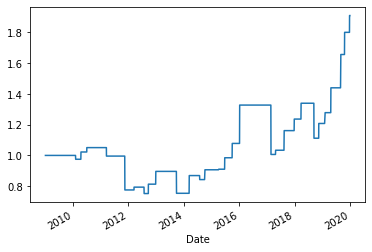

In [ ]:
book['acc return'].plot()